In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt

from concept_detection.text.io import read_json

In [3]:
data = read_json('enwiki-20220421-20180215-query_explorer.json')

In [4]:
features = data['_source']['model']['feature_set']['features']
feature_names = [feature['name'] for feature in features]

model = data['_source']['model']['model']['definition']

features = pd.DataFrame(features)
features['type'] = features['template'].astype(str).str.extract(r"\{\'(.*?)\'")

features['type'][features['type'].isna()] = features['template_language'][features['type'].isna()]

def split_name(row):
    if row['type'] == 'match':
        matches = re.split(r"(.*)_(match)", row['name'])
        return [match for match in matches if match]

    if row['type'] == 'match_explorer':
        matches = re.split(r"(.*)_(classic_idf|raw_ttf|unique_terms)", row['name'])
        matches = [match for match in matches if match]
        submatches = re.split(r"(.*)_(min|max|mean|stddev)", matches[0])
        submatches = [submatch for submatch in submatches if submatch]
        return submatches + matches[1:]

    if row['type'] == 'derived_expression':
        matches = re.split(r"(.*)_(?:dismax|unique_terms_diff)_(.*)", row['name'])
        if len(matches) > 1:
            matches = [match for match in matches if match]
            if 'plain' in matches:
                matches.remove('plain')
                matches.append(matches[0] + '_plain')
                return matches
        
        matches = re.split(r"(.*)_or_(.*)_dismax", row['name'])
        return [match for match in matches if match]
    
    if row['type'] == 'token_count_router':
        matches = re.split(r"(.*)_(phrase_match)", row['name'])
        return [match for match in matches if match]

    if row['type'] == 'function_score':
        return [row['name']]
    
    return []

features['split_name'] = features.apply(split_name, axis=1)

features.head()

,name,params,template_language,template,type,split_name
0,title_match,[query_string],mustache,{'match': {'title': '{{query_string}}'}},match,"[title, match]"
1,title_stddev_classic_idf,[query_string],mustache,{'match_explorer': {'query': {'match': {'title...,match_explorer,"[title, stddev, classic_idf]"
2,title_plain_match,[query_string],mustache,{'match': {'title.plain': '{{query_string}}'}},match,"[title_plain, match]"
3,title_plain_max_classic_idf,[query_string],mustache,{'match_explorer': {'query': {'match': {'title...,match_explorer,"[title_plain, max, classic_idf]"
4,title_plain_mean_classic_idf,[query_string],mustache,{'match_explorer': {'query': {'match': {'title...,match_explorer,"[title_plain, mean, classic_idf]"


In [5]:
def get_tree_fields(tree):
    if 'leaf' in tree:
        return set()

    assert len(tree['children']) == 2
    assert tree['yes'] == tree['missing']
    fields_0 = get_tree_fields(tree['children'][0])
    fields_1 = get_tree_fields(tree['children'][1])
    
    return set([tree['split']]) | fields_0 | fields_1

In [6]:
field_matches = []

for tree in model:
    fields = get_tree_fields(tree)
    field_matches.append([name in fields for name in feature_names])

In [7]:
fields = pd.DataFrame(field_matches, columns=feature_names)

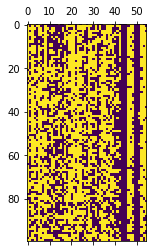

In [8]:
fig, ax = plt.subplots()
ax.matshow(fields)

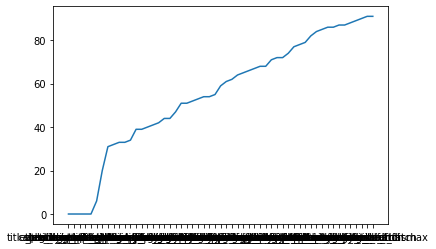

In [9]:
agg_fields = fields.sum().sort_values()

fig, ax = plt.subplots()
ax.plot(agg_fields)

In [10]:
agg_fields[agg_fields < 20]

title_plain_unique_terms         0
text_dismax_plain                0
text_match                       0
title_unique_terms               0
opening_text_dismax_plain        0
title_unique_terms_diff_plain    6
dtype: int64

In [11]:
agg_fields[agg_fields > 80]

redirect_title_plain_match     82
title_plain_match              84
popularity_score               85
all_phrase_match               86
text_word_count                86
incoming_links                 87
text_sum_classic_idf           87
category_match                 88
text_or_opening_text_dismax    89
text_plain_match               90
redirect_title_match           91
title_match                    91
dtype: int64

In [12]:
def nav(tree, path=None):
    if path is None or not path:
        return tree
    
    return nav(tree['children'][path[0]], path[1:])

nav(model[0], [0, 1, 0, 1, 0, 0])

{'nodeid': 83,
 'split': 'redirect_title_match',
 'split_condition': 19.2012424,
 'yes': 165,
 'no': 166,
 'missing': 165,
 'depth': 6,
 'children': [{'nodeid': 165, 'leaf': 0.994905859},
  {'nodeid': 166, 'leaf': 1.2001237869999999}]}

In [13]:
def get_n_nodes(tree):
    if 'leaf' in tree:
        return 1
    
    n_nodes_0 = get_n_nodes(tree['children'][0])
    n_nodes_1 = get_n_nodes(tree['children'][1])
    
    return 1 + n_nodes_0 + n_nodes_1

total_n_nodes = sum([get_n_nodes(tree) for tree in model])
total_n_nodes

17098

In [14]:
def reduce(tree, threshold=1e-4):
    if 'leaf' in tree:
        return tree
    
    if tree['split_condition'] < threshold:
        return reduce(tree['children'][1], threshold)
    
    tree['children'][0] = reduce(tree['children'][0])
    tree['children'][1] = reduce(tree['children'][1])

    return tree